In [2]:
shhh <- suppressPackageStartupMessages
shhh(library(data.table))
shhh(library(ggplot2))
shhh(library(stringr))
shhh(library(ggpubr))
shhh(library(transite))
shhh(library(Biostrings))

In [3]:
shhh(library(BSgenome.Hsapiens.UCSC.hg38))
Hsapiens = BSgenome.Hsapiens.UCSC.hg38
shhh(library(Biostrings))
shhh(library(matrixStats))
shhh(library(ggrepel))
shhh(library(patchwork))

In [4]:
library('Cairo')
CairoFonts(
regular="Sans:style=Light",
bold="Sans:style=Bold",
italic="Sans:style=Oblique",
bolditalic="Sans:style=BoldOblique"
)

In [5]:
kmer_analysis2 = function(bg_seq, fg_seq, kmer = 6, thres = 0.05, remove_homopolymer = F){
    # background_kmer = generateKmers2(seq, kmer, Correction = T) 
    # foreground_kmer  = generateKmers2(seq[names(seq) %in% ID_list], kmer, Correction = T) 
    background_kmer = generate_kmers(bg_seq, kmer) 
    foreground_kmer  = generate_kmers(fg_seq, kmer) 
    Enrich <- 
    compute_kmer_enrichment(foreground_kmer,
                            background_kmer,
                            permutation = FALSE, 
                            chisq_p_value_threshold = 0.05,
                            p_adjust_method = "BH")
    dt <- as.data.table(Enrich)
    dt[, kmer := names(foreground_kmer)]
    dt <- dt[, c(6, 1:5)]
    
    # log transform enrichment and adjust.p.values
    dt[, log2_enrichment := log2(as.numeric(enrichment))]
    dt[, log_padj := -log10(as.numeric(adj_p_value))]
  
    # group kmer based on signficance
    dt[, group := "n"] # not significant
    dt[enrichment > 1 & adj_p_value <= thres, group := "e"] # enriched
    dt[enrichment < 1 & adj_p_value <= thres, group := "d"] # depleted
  
    # order the table starting from the largest enrichment 
    dt <- dt[order(-enrichment)]

    #remove kmer that has 5 consecutive same nts
    homopolymer_list <- "AAAAA|TTTTT|GGGGG|CCCCC|AAAA|TTTT|GGGG|CCCC|AAA|GGG|TTT"
    if (remove_homopolymer  == T){
        dt = dt[!(str_detect(kmer, homopolymer_list))]
    }
    
    return(dt)
}

In [6]:
volcano.plot2 <- function(kmer.enrichment, thres = 0.05, x_range = c(-1, 1), size1 = 8, size2 = 6, label_size = 1){
  ggplot(kmer.enrichment,
         aes(log2_enrichment,
             log_padj,
             color = group)) + 
  geom_point(size = 0.5, aes(alpha = log_padj), show.legend = F) +  #
  scale_color_manual(
                values = c(
                    "n" = "#8c8c8c",
                    "e" = "#440154FF",
                    "d" = "#22A884FF"),
                breaks = c("e", "d", "n"),
                labels = c("Enriched", "Depleted", "ns"),
                name = "") +
  #scale_alpha_manual(values = c(0.4, 0.2, 0.4),guide = FALSE) +
  geom_hline(yintercept = -log10(thres), linewidth = 0.2, linetype = "dotted") +
  scale_x_continuous(name = expression(log[2](FC)), limits = x_range) +
  ylab(expression(-log[10](q))) +
  theme_bw(base_size = size1) +
  geom_text_repel(aes(label = ifelse(text_label == "e", as.character(kmer),'')), 
                  nudge_x      = 0.1,
                  nudge_y      = 0.5,
#                 direction    = "y",
#                 hjust        = 0,
#                 vjust        = 0.1,
                  segment.size = 0.05,
                  size = label_size, 
                  show.legend = F,
                  max.overlaps = Inf) +
  geom_text_repel(aes(label = ifelse(text_label == "d", as.character(kmer),'')),
                  nudge_x      = -0.1,
                  nudge_y      = 0.5,
#                   direction    = "y",
#                   hjust        = 0,
#                   vjust        = 0.2,
                    segment.size = 0.05,
                    size         = label_size,
                    show.legend = F,
                    max.overlaps = Inf) +
  theme(
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.background = element_blank(),
    axis.text.y = element_text(size = size2),
    axis.text.x = element_text(size = size2),
    legend.position = "top",
    strip.background = element_rect("white"),
    strip.text = element_text(size = size2)) 
}

In [7]:
kmer_wrappper2 = function(fg_seq, bg_seq){
    kmers = kmer_analysis2(bg_seq, fg_seq, kmer = 6, remove_homopolymer = T)
    kmers[, kmer := str_replace_all(kmer, "T", "U")]
    kmers[, group := "n"] # not significant
    kmers[enrichment > 1 & adj_p_value <= 0.01 , group := "e"] # enriched # & !(str_detect(kmer, "AAA"))
    kmers[enrichment < 1 & adj_p_value <= 0.01 , group := "d"] # depleted # & !(str_detect(kmer, "AAA"))
    kmers[, text_label := "n"]
    kmers[group == "e" & adj_p_value <= sort(kmers[group == "e",adj_p_value])[min(nrow(kmers[group == "e"]), 10)], text_label := "e"]
    kmers[group == "d" & adj_p_value <= sort(kmers[group == "d",adj_p_value])[min(nrow(kmers[group == "d"]), 10)], text_label := "d"]
    return(kmers)
}

## Load polyA sites

In [8]:
apa = fread("Fig_3b_TDP43-7D-KD-APA_for-motif-analysis.csv")

In [9]:
head(apa)

cluster_ID,gene_id,PAS_cluster_ID,PAS_ID,delta_usage,usage_direction,padj,lc_gene_padj,chr,PAS,strand,updated_polyA_site
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>
ENSG00000000419.14@chr20:50934851:50934877:-,ENSG00000000419.14,chr20:50934851:50934877:-,chr20:50934872:-,0.003131453,up,2.305600e-01,0.498977376,chr20,50934872,-,50934870
ENSG00000000419.14@chr20:50934941:50934959:-,ENSG00000000419.14,chr20:50934941:50934959:-,chr20:50934945:-,-0.003131453,down,2.305600e-01,0.498977376,chr20,50934945,-,50934945
ENSG00000000457.14@chr1:169849622:169849685:-,ENSG00000000457.14,chr1:169849622:169849685:-,chr1:169849631:-,0.192683025,up,5.558631e-05,0.021208938,chr1,169849631,-,169849631
ENSG00000000457.14@chr1:169853078:169853094:-,ENSG00000000457.14,chr1:169853078:169853094:-,chr1:169853090:-,-0.192683025,down,5.558631e-05,0.021208938,chr1,169853090,-,169853089
ENSG00000001036.14@chr6:143493951:143493962:-,ENSG00000001036.14,chr6:143493951:143493962:-,chr6:143493954:-,0.239089445,up,5.303030e-21,0.003237899,chr6,143493954,-,143493954
ENSG00000001036.14@chr6:143495476:143495491:-,ENSG00000001036.14,chr6:143495476:143495491:-,chr6:143495487:-,-0.239089445,down,4.827154e-28,0.003237899,chr6,143495487,-,143495487


### Select polyA sites for comparision

In [22]:
Upregulated_PASIDs = apa[padj < 0.05 & delta_usage > 0.1, PAS_ID]
Downregulated_PASIDs = apa[padj < 0.05 & delta_usage < -0.1, PAS_ID]



In [23]:
length(Upregulated_PASIDs)
length(Downregulated_PASIDs)

[1] 14147

[1] 14147

[1] 2433

[1] 2455

## Sequence features downstream of the PAS [10, 50]

UG rich motif in DSE is located +11-+33 downstream of the polyA site

In [40]:
pas_ds50_dt = copy(apa[, .(PAS_ID, chr, PAS, strand)])
pas_ds50_dt[, start := ifelse(strand == "+", PAS+10,  PAS-50)]
pas_ds50_dt[, end := ifelse(strand == "+",   PAS+50, PAS-10)]

In [41]:
ds50_seq = getSeq(Hsapiens, 
                  pas_ds50_dt$chr, 
                  start   = pas_ds50_dt$start, 
                  end     = pas_ds50_dt$end, 
                  strand  = pas_ds50_dt$strand)
names(ds50_seq) =  pas_ds50_dt$PAS_ID

### kmer analysis

In [46]:
ds50_kmer_up_vs_dn = kmer_wrappper2(ds50_seq[names(ds50_seq) %in% Upregulated_PASIDs],
                                    ds50_seq[names(ds50_seq) %in% Downregulated_PASIDs])


   e    n 
   2 3436 

   n 
3438 


## Sequence features further downstream of the PAS [51, 100]

In [70]:
pas_ds100_dt = copy(apa[, .(PAS_ID, chr, PAS, strand)])
pas_ds100_dt[, start := ifelse(strand == "+", PAS+51,  PAS-100)]
pas_ds100_dt[, end := ifelse(strand == "+",   PAS+100, PAS-51)]

In [71]:
ds100_seq = getSeq(Hsapiens, 
                  pas_ds100_dt$chr, 
                  start   = pas_ds100_dt$start, 
                  end     = pas_ds100_dt$end, 
                  strand  = pas_ds100_dt$strand)
names(ds100_seq) =  pas_ds100_dt$PAS_ID

### kmer analysis

In [72]:
ds100_up_vs_dn_kmer = kmer_wrappper2(ds100_seq[names(ds100_seq) %in% Upregulated_PASIDs],
                                     ds100_seq[names(ds100_seq) %in% Downregulated_PASIDs])


   d    n 
   1 3437 

   e    n 
   2 3436 


## Sequence features upstream of the PAS [-50, -10]

In [81]:
pas_us50_dt = copy(apa[, .(PAS_ID, chr, PAS, strand)])
pas_us50_dt[, start := ifelse(strand == "+", PAS-50,  PAS+10)]
pas_us50_dt[, end := ifelse(strand == "+",   PAS-10, PAS+50)]

In [82]:
us50_seq = getSeq(Hsapiens, 
                  names   = pas_us50_dt$chr, 
                  start   = pas_us50_dt$start, 
                  end     = pas_us50_dt$end, 
                  strand  = pas_us50_dt$strand)
names(us50_seq) =  pas_us50_dt$PAS_ID

### kmer analysis

In [86]:
us50_up_vs_dn_kmer = kmer_wrappper2(us50_seq[names(us50_seq) %in% Upregulated_PASIDs],
                                    us50_seq[names(us50_seq) %in% Downregulated_PASIDs])


   e    n 
   1 3437 

   d    n 
   1 3437 


## Sequence features further upstream of the PAS [-100, -50]

In [93]:
pas_us100_dt = copy(apa[, .(PAS_ID, chr, PAS, strand)])
pas_us100_dt[, start := ifelse(strand == "+", PAS-100,  PAS+51)]
pas_us100_dt[, end := ifelse(strand == "+",   PAS-51, PAS+100)]

In [94]:
us100_seq = getSeq(Hsapiens, 
                  names   = pas_us100_dt$chr, 
                  start   = pas_us100_dt$start, 
                  end     = pas_us100_dt$end, 
                  strand  = pas_us100_dt$strand)
names(us100_seq) =  pas_us100_dt$PAS_ID

### kmer analysis

In [97]:
us100_up_vs_dn_kmer = kmer_wrappper2(us100_seq[names(us100_seq) %in% Upregulated_PASIDs],
                                     us100_seq[names(us100_seq) %in% Downregulated_PASIDs] 
                                     )


   n 
3438 

   d    e    n 
   1    3 3434 


## combined plots for fig. 2h

In [123]:
us100_kmers_up_vs_dn_plot = volcano.plot2(na.omit(us100_up_vs_dn_kmer), 
                                        thres  = 0.05, 
                                        size1 = 6, 
                                        label_size = 1, 
                                        x_range = c(-4, 4))

us50_kmers_up_vs_dn_plot = volcano.plot2(na.omit(us50_up_vs_dn_kmer), 
                                        thres  = 0.05, 
                                        size1 = 6, 
                                        label_size = 1, 
                                        x_range = c(-4, 4))

ds50_kmers_up_vs_dn_plot = volcano.plot2(na.omit(ds50_kmer_up_vs_dn), 
                                        thres  = 0.05, 
                                        size1 = 6, 
                                        label_size = 1, 
                                        x_range = c(-4, 4))

ds100_kmers_up_vs_dn_plot = volcano.plot2(na.omit(ds100_up_vs_dn_kmer), 
                                        thres  = 0.05, 
                                        size1 = 6, 
                                        label_size = 1, 
                                        x_range = c(-4, 4))

In [124]:
options(repr.plot.width=16, repr.plot.height=4)

hexamer_plot = us100_kmers_up_vs_dn_plot + us50_kmers_up_vs_dn_plot + ds50_kmers_up_vs_dn_plot + ds100_kmers_up_vs_dn_plot + plot_layout(nrow = 1)

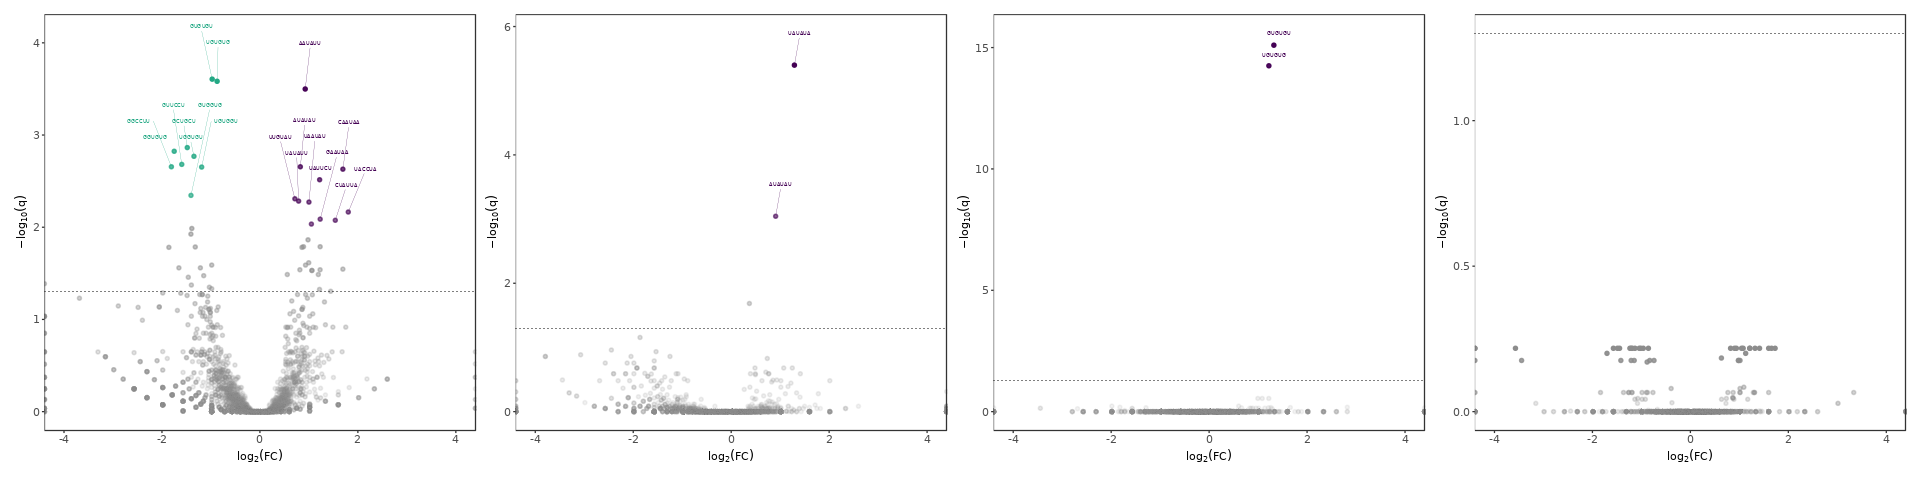

In [125]:
hexamer_plot

In [126]:
ggsave(hexamer_plot, filename = "Revision_figures/fig_2e_hexamer_plot.pdf", height = 1.5, width = 6, units = "in")